<a href="https://colab.research.google.com/github/Netz00/Data-science/blob/main/labs/seminar/DataScienceProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> Uvod u podatkovnu znanost  </h1></center>
<center><h2> Analiza podataka o zaposlenicima FESB-a </h2></center> 
<center><h3> Seminar </h3></center> 
<center><h3> B. Durdov, D. Glavina  </h3></center> 


Seminar se bavi prikupljanjem javno dostupnih podataka sa stranice https://nastava.fesb.unist.hr/nastava te njihovom obradom.
Zatim te podatke kombinira s [Google Scholar](https://scholar.google.com/) podacima.
Poglavlja
1. Postavljanje okoline
2. Dohvaćanje inicijalnih podataka
3. Proširivanje inicijalnih podataka scrapingom
4. Analiza proširenih podataka
5. koraku se podaci spajaju s podacima Google Scholar-a te analiziraju.


# Postavljanje okoline

Instalacija potrebnih biblioteka.

In [ ]:
!pip3 install pandas selenium beautifulsoup4 requests matplotlib seaborn
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

Konfiguriranje Seaborn palete boja.

In [ ]:
# define Seaborn color palette to use
palette_color = sns.color_palette('pastel')[0:5]


## Početni dataset
Dataset je dobiven kopiranjem HTML tagova sa stranice [FESB nastava](https://nastava.fesb.unist.hr/nastava) i njegovim uređivanjem te pretvaranjem u .CSV format pomoću text editora VS Code
  - Dvostruka imena i prezimena odvojena zarezom, detektirana su tako što se u Excelu vidi koji redak iskače, pa su se ručno grupirala odvojena razmakom.

Postupak je ponovljen za djelatnike i vanjske suradnike što je rezultiralo s dvije datoteke:
- [djelatnici.scv](./djelatnici.csv)
- [vanjskiSuradnici.scv](./vanjskiSuradnici.csv)


Zatim su podaci nastavnika i vanjskih suradnika spojeni u zajedničku datoteku [default.scv](./default.csv) s dodatnim stupcem `type` (djelatnik ili vanjski suradnik), nedostajući stupci kod vanjskih suradnika su ispunjeni NULL vrijednostima.

Finalni [Dataset](./default.csv) sadržava:
- lastName
- firstName
- detailsLink
- image
- deparment_short
- location
- details
- type



In [ ]:
employees = pd.read_csv("djelatnici.csv")

print(employees.shape)
employees.head()

(160, 6)


,detailsLink,image,lastName,firstName,deparment_short,location
0,https://nastava.fesb.unist.hr/nastava/nastavni...,NaN,Aljinović,Amanda,ZPS,C405
1,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.unist.hr/slika/mala/pstr...,Bagavac,Petra,ZSB,C705
2,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/dbajic.jpg,Bajić,Dražen,ZPS,C411
3,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/darioban.jpg,Ban,Dario,ZSB,C804
4,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/fbarbir.jpg,Barbir,Frano,ZSB,C513


In [ ]:
employees = pd.read_csv("vanjskiSuradnici.csv")

print(employees.shape)
employees.head()

(116, 4)


,detailsLink,image,lastName,firstName
0,https://nastava.fesb.unist.hr/nastava/nastavni...,NaN,Babić,Josip
1,https://nastava.fesb.unist.hr/nastava/nastavni...,NaN,Baković,Miljenko
2,https://nastava.fesb.unist.hr/nastava/nastavni...,NaN,Barišić,Marko
3,https://nastava.fesb.unist.hr/nastava/nastavni...,NaN,Bašić,Martina
4,https://nastava.fesb.unist.hr/nastava/nastavni...,NaN,Batalić,Neven


In [ ]:
employees = pd.read_csv("default.csv")

print(employees.shape)
employees.head()

(276, 7)


,detailsLink,image,lastName,firstName,deparment_short,location,type
0,https://nastava.fesb.unist.hr/nastava/nastavni...,NaN,Aljinović,Amanda,ZPS,C405,djelatnik
1,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.unist.hr/slika/mala/pstr...,Bagavac,Petra,ZSB,C705,djelatnik
2,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/dbajic.jpg,Bajić,Dražen,ZPS,C411,djelatnik
3,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/darioban.jpg,Ban,Dario,ZSB,C804,djelatnik
4,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/fbarbir.jpg,Barbir,Frano,ZSB,C513,djelatnik


## Određivanje spola
Sljedeći korak je obogatiti dataset inflormacijom o spolu, te rezultira s proširenim datasetom [defaultSex](./defaultSex.csv).

Određivanje spola temelji se na temelju imena i iskustvu procjenitelja

Koraci:
1.   Izvući sva jedinstvena imena
2.   Izvući zadnja dva znaka iz tih imena
3.   Izvući sve jedinstvene parove tih znakova

In [ ]:
# agregiraj imena
vc = employees.groupby(["firstName"])["firstName"].count()

# izvuci samo zadja dva znaka svih imena
vc=vc.index
lastChars=[]
for name in vc:
    lastChars.append(name[-2:])

# agregiraj zadnja dva znaka imena
d={'chars': lastChars}
df = pd.DataFrame(data=d)
df= df.groupby(["chars"])["chars"].count()

print(df.index.tolist())

['an', 'ao', 'ar', 'av', 'ca', 'da', 'ea', 'el', 'en', 'eo', 'ia', 'il', 'in', 'io', 'ip', 'ir', 'is', 'ja', 'je', 'jo', 'ka', 'ko', 'la', 'li', 'na', 'ne', 'ni', 'no', 'nt', 'oj', 'or', 'ov', 'pa', 'pe', 'po', 'ra', 're', 'ri', 'ro', 'rt', 'ta', 'te', 'ul', 'vo', 'ći', 'ša', 'šo', 'ža', 'žo']


Obraditi prethodno generirani niz, tako da se za svaki znak provjerava:
- ako su sva muška imena, staviti taj niz s dva znaka u redak MALE
- ako su sva zenska imena stavit taj niz od dva znaka u redak FEMALE
- inace stavit u neodredeno

Za sve neodredjene proširiti rucno niz za 1 znak, ponovit postupak, i nastavit širenje dok UNKNOWN nije prazno ili nailaska korištenja UNISEX imena.

In [ ]:
male = ['an', 'ao', 'ar', 'av', 'el', 'en', 'eo', 'il', 'in', 'io', 'ip', 'ir', 'je', 'jo', 'ko', 'li', 'ne', 'no', 'nt', 'oj', 'or', 'ov', 'pe', 'po', 're', 'ri', 'ro', 'rt', 'te', 'ul', 'vo', 'ći', 'ša', 'žo', 'ni', 'vica', 'rica', 'is', 'drija', 'tija', 'lja', 'ola']
female = ['da', 'ea', 'ia', 'ka', 'na', 'pa', 'ra', 'ta', 'ža', 'čica', 'tica', 'arija', 'nja', 'aja', 'ela', 'rla', 'ila']

Sortirati nizove po duljima elemenata.

In [ ]:
# Sort by length of ending pattern
maleByLength=sorted(male, key=len, reverse=True)
femaleByLength=sorted(female, key=len, reverse=True)
print("male = ",maleByLength)
print("female = ",femaleByLength)

male =  ['drija', 'vica', 'rica', 'tija', 'lja', 'ola', 'an', 'ao', 'ar', 'av', 'el', 'en', 'eo', 'il', 'in', 'io', 'ip', 'ir', 'je', 'jo', 'ko', 'li', 'ne', 'no', 'nt', 'oj', 'or', 'ov', 'pe', 'po', 're', 'ri', 'ro', 'rt', 'te', 'ul', 'vo', 'ći', 'ša', 'žo', 'ni', 'is']
female =  ['arija', 'čica', 'tica', 'nja', 'aja', 'ela', 'rla', 'ila', 'da', 'ea', 'ia', 'ka', 'na', 'pa', 'ra', 'ta', 'ža']


Izgraditit pravila za odlučivanje radi li se o muškom ili ženskom imenu pomoću prethodnih lista na sljedeći način:
1. Grupirati elemente listi po duljini
2. Ispituje se jeli ime završava s jednim od elemenata iz te grupe
3. Ispitivanje se vrši od dužih prema kraćim sekvencama

In [ ]:
# group sections of same length and check if NAME ends with the pattern
def getSexByFirstName(name):
    name.lower()
    if (re.search("(drija|vica|rica|tija)$", name)!=None):
        return 'MALE'
    elif (re.search("(arija)$", name)!=None):
        return 'FEMALE'
    elif (re.search("(čica|tica)$", name)!=None):
        return 'FEMALE'
    elif (re.search("(nja|aja|ela|rla|ila)$", name)!=None):
        return 'FEMALE'
    elif (re.search("(lja|ola)$", name)!=None):
        return 'MALE'
    elif (re.search("(an|ao|ar|av|el|en|eo|il|in|io|ip|ir|je|jo|ko|li|ne|no|nt|oj|or|ov|pe|po|re|ri|ro|rt|te|ul|vo|ći|ša|žo|ni|is)$", name)!=None):
        return 'MALE'
    elif (re.search("(da|ea|ia|ka|na|pa|ra|ta|ža)$", name)!=None):
        return 'FEMALE'            

# TEST
print(getSexByFirstName("Stipe"))
print(getSexByFirstName("Ante"))

MALE
MALE


Koristeći prethodnu funkciju odrediti spol za svaki redak i spremiti rezultate u `defaultSex.csv`.

``` bash
❗ Ručno izbrisati defaultSex.csv ukoliko postoji već da bi se promjene spremile.
```
``` python
# Wont't work!
import os
os.remove("defaultSex.csv")
```

In [ ]:
# Add new column
employees['sex'] = ""     
    
for index, row in employees.iterrows():
    employees.at[index,'sex'] = getSexByFirstName(row['firstName'])

# Save updated dataframe
employees.to_csv('defaultSex.csv')

# Scraping


Koristeći `detailsLink` stupac scrape-ati dodatne podatke za svakog zaposlenika.
Dodatni podaci (stupci) su:
- e-mail adresa
- lokacija ureda
- zavod
- titula
- pozicija

Korak rezultira s proširenim datasetom [defaultSexScrape.csv](./defaultSexScrape.csv).

## Definiranje scraping funkcija
- izrada custom funkcija za scraping
- pisanje testova za funkcije

Definirajmo funkcije za dohvaćanje:
- putem linka HTML stranice
  - putem HTML stranice 
    - e-mail adrese
    - lokacije ureda
    - zavoda
    - titule
    - pozicije


In [ ]:
def getPageFromLink(link):
    page = requests.get(link)
    if page.status_code != 200:
        # print("status code: ", page.status_code)
        return None
    soup = BeautifulSoup(page.content, 'html.parser')
    return soup

def getEmailFromDetailsPage(soup):
    if soup is None:
      return 'NULL'
    email = soup.find('div', attrs={'class':'infoItem mail clearfix'}).select("div a")[0].text
    return email

def getLocationFromDetailsPage(soup):
    if soup is None:
      return 'NULL'
    location = soup.find('div', attrs={'class':'infoContent'}).text
    location=re.search(r"([A-C]{1}\d{3})", location)
    if location:
        return location.group()
    else:
        return 'NULL'

def getDepartmentFromDetailsPage(soup):
    if soup is None:
      return 'NULL'
    department = soup.select('#user-info > div.sidebar > div.userGeneralInfo > div.infoItem.location.clearfix > div.infoContent')
    if not department:
        return 'NULL'
    department = department[0].text
    department=re.search(r"(\s*)(.+)(,\s*)([A-Z][1-9][0-9]{2})(\s+)$", department)
    if department:
        return department.group(2)
    else:
        return 'NULL'

def getTitleFromDetailsPage(soup):
    if soup is None:
      return 'NULL'
    title = soup.select('#user-info > div.heading.clearfix > div > div > span.title')
    if not title:
        return 'NULL'
    title = title[0].text
    if title == "":
        return 'NULL'
    else:
        return title

def getPositionFromDetailsPage(soup):
    if soup is None:
      return 'NULL'
    position = soup.select('#user-info > div.heading.clearfix > div > div > span.position')
    if not position:
        return 'NULL'
    position = position[0].text
    if position == "":
        return 'NULL'
    else:
        return position

# TEST

tests=[
          {
              'url':'https://nastava.fesb.unist.hr/nastava/nastavnici/detalji/mdujmovic',
              'email':'Miroslav.Dujmovic@fesb.hr',
              'location':'NULL',
              'department':'NULL',
              'title':'mr. sc.',
              'position':'naslovno zvanje asistent'
          },
          {
              'url':'https://nastava.fesb.unist.hr/nastava/nastavnici/detalji/idjapic',
              'email':'NULL',
              'location':'NULL',
              'department':'NULL',
              'title':'NULL',
              'position':'NULL'
          },
          {
              'url':'https://nastava.fesb.unist.hr/nastava/nastavnici/detalji/dbajic',
              'email':'Drazen.Bajic@fesb.hr',
              'location':'NULL',
              'department':'Zavod za proizvodno strojarstvo',
              'title':'dr. sc.',
              'position':'redoviti profesor - trajno zvanje'
          },
          {
              'url':'https://nastava.fesb.unist.hr/nastava/nastavnici/detalji/mandru00',
              'email':'Martina.Andrun.00@fesb.hr',
              'location':'C807',
              'department':'Zavod za strojarstvo i brodogradnju',
              'title':'mag. ing.',
              'position':'asistent'
          },
          {
              'url':'https://nastava.fesb.unist.hr/nastava/nastavnici/detalji/bugarinm',
              'email':'Miro.Bugarin@fesb.hr',
              'location':'C702',
              'department':'NULL',
              'title':'dr. sc.',
              'position':'docent'
          },
          {
              'url':'https://nastava.fesb.unist.hr/nastava/nastavnici/detalji/plavsabm',
              'email':'Mira.Braovic.Plavsa@fesb.hr',
              'location':'A115',
              'department':'Odsjek općih predmeta',
              'title':'prof.',
              'position':'viši predavač'
          },
          {
              'url':'https://nastava.fesb.unist.hr/nastava/nastavnici/detalji/marijuki',
              'email':'Marija.Jukic.Ante@fesb.hr',
              'location':'A225',
              'department':'Računski centar',
              'title':'mag. ing.',
              'position':'naslovno zvanje asistent'
          }
]

# TEST RUNNER

for test in tests:

  page = getPageFromLink(test['url'])

  test.pop("url")
  result={
          'email':getEmailFromDetailsPage(page),
          'location':getLocationFromDetailsPage(page),
          'department':getDepartmentFromDetailsPage(page),
          'title':getTitleFromDetailsPage(page),
          'position':getPositionFromDetailsPage(page)
  }


  if test!=result:
    print('TEST FAILED')
    print("Expected :", test)
    print("Actual   :",result)
  else:
    print("TEST PASSED")

TEST PASSED
TEST PASSED
TEST PASSED
TEST PASSED
TEST PASSED
TEST PASSED
TEST PASSED


## Scraping podataka
Pomoću prethodnih funkcija:
- getEmailFromDetailsPage
- getLocationFromDetailsPage
- getDepartmentFromDetailsPage
- getTitleFromDetailsPage
- getPositionFromDetailsPage

Za svaki redak obogatiti CSV datoteku podacima:
- email
- lokacija ureda
- zavod
- titula
- pozicija

Scraping će također otkriti mrtve linkove.

In [ ]:
employees['email'] = "NULL"
employees['location'] = "NULL"
employees['department'] = "NULL"
employees['title'] = "NULL"
employees['position'] = "NULL"

invalidLinkCounter=0

for index, row in employees.iterrows():

    page = getPageFromLink(row['detailsLink'])

    email=getEmailFromDetailsPage(page)
    location=getLocationFromDetailsPage(page)
    department=getDepartmentFromDetailsPage(page)
    title=getTitleFromDetailsPage(page)
    position=getPositionFromDetailsPage(page)

    if page is None:
        invalidLinkCounter=invalidLinkCounter+1
        print("invalid links counter: ",invalidLinkCounter)
        print("link: "+row['detailsLink'])
        print()

    employees.at[index,'email'] = email
    employees.at[index,'location'] = location
    employees.at[index,'department'] = department
    employees.at[index,'title'] = title
    employees.at[index,'position'] = position

employees.to_csv('defaultSexScrape.csv')

invalid links counter:  1
link: https://nastava.fesb.unist.hr/nastava/nastavnici/detalji/idjapic

invalid links counter:  2
link: https://nastava.fesb.unist.hr/nastava/nastavnici/detalji/ploncar



# Analiza



Analiza prikupljenih podataka.

Dataset:
-	**type**
-	**sex**
-	**department**
-	**title**
-	**position**

Ostali podaci nisu relevantni:
- detailsLink
- image
-	lastName
-	firstName
-	deparment_short
-	location
-	email

Učitavanje nadopunjene verzije csv datoteke.

In [ ]:
employees = pd.read_csv("defaultSexScrape.csv")
print(employees.shape)
employees.head()

(276, 13)


,Unnamed: 0,detailsLink,image,lastName,firstName,deparment_short,location,type,sex,email,department,title,position
0,0,https://nastava.fesb.unist.hr/nastava/nastavni...,NaN,Aljinović,Amanda,ZPS,C405,djelatnik,FEMALE,Amanda.Aljinovic@fesb.hr,Zavod za proizvodno strojarstvo,mag. ing.,asistent
1,1,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.unist.hr/slika/mala/pstr...,Bagavac,Petra,ZSB,C705,djelatnik,FEMALE,Petra.Bagavac@fesb.hr,Zavod za strojarstvo i brodogradnju,dr. sc.,Poslijedoktorand
2,2,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/dbajic.jpg,Bajić,Dražen,ZPS,NaN,djelatnik,MALE,Drazen.Bajic@fesb.hr,Zavod za proizvodno strojarstvo,dr. sc.,redoviti profesor - trajno zvanje
3,3,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/darioban.jpg,Ban,Dario,ZSB,C804,djelatnik,MALE,Dario.Ban@fesb.hr,Zavod za strojarstvo i brodogradnju,dr. sc.,izvanredni profesor
4,4,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/fbarbir.jpg,Barbir,Frano,ZSB,C513,djelatnik,MALE,Frano.Barbir@fesb.hr,Zavod za strojarstvo i brodogradnju,dr. sc.,redoviti profesor - trajno zvanje


## Osnovna analiza
Koristi samo prikupljene podatke.

Koliko se jedinstvenih prezimena ovdje nalazi (iako su neka prezimena kombinacija postojećih prezimena)?

In [ ]:
uniqueEmployees = len(employees['lastName'].unique())
all = len(employees)
print("Unique employees",uniqueEmployees,"/",all)

Unique employees 253 / 276


Koliko je djelatnika s istim prezimenom se zaposlilo samo jednom naspram više puta?

In [ ]:
vc = employees["lastName"].value_counts()
once = len(vc[vc == 1])
more_than_once = len(vc[vc > 1])

print(vc)
print("Single occurrence",once)
print("Multiple occurrences",more_than_once)

Marasović    4
Bašić        4
Blažević     3
Grgić        3
Pivac        2
            ..
Nižetić      1
Papić        1
Pehnec       1
Pekić        1
Žilić        1
Name: lastName, Length: 253, dtype: int64
Single occurrence 236
Multiple occurrences 17


Koliko je jedinstvenih titula?
Koliko je svake od titula?

In [ ]:
vc = employees["title"].value_counts()
once = len(vc[vc == 1])
more_than_once = len(vc[vc > 1])

print(vc)
print("\nOnly once",once)
print("More than once",more_than_once)

dr. sc.       150
mag. ing.      68
dipl. ing.     15
mr. sc.         4
prof.           4
mag. math.      4
mag. phys.      4
Name: title, dtype: int64

Only once 0
More than once 7


Koliki je omjer zaposlenika, djelatnika i vanjskih suradnika, prema spolu?

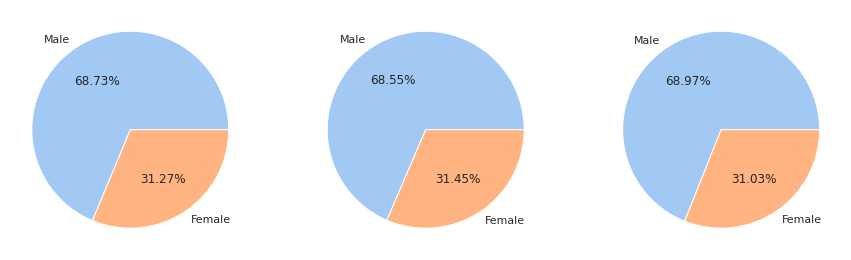

In [ ]:
allSexRatio = employees["sex"].value_counts(normalize=True) * 100
externalsSexRatio= employees[employees["type"] == 'djelatnik']["sex"].value_counts(normalize=True) * 100
internalsSexRatio= employees[employees["type"] == 'vanjski_suradnik']["sex"].value_counts(normalize=True) * 100

# svi
dataAll = [allSexRatio['MALE'], allSexRatio['FEMALE']]
# vanjski suradnici
dataExternals = [externalsSexRatio['MALE'], externalsSexRatio['FEMALE']]
# zaposlenici
dataInternals = [internalsSexRatio['MALE'], internalsSexRatio['FEMALE']]

keys = ['Male', 'Female']
  
# Make figure and axes
fig, axs = plt.subplots(ncols=3,figsize=(15, 5))

# A standard pie plot
axs[0].pie(allSexRatio, labels=keys, colors=palette_color, autopct='%.2f%%')
axs[1].pie(dataExternals, labels=keys, colors=palette_color, autopct='%.2f%%')
axs[2].pie(dataInternals, labels=keys, colors=palette_color, autopct='%.2f%%')

plt.show()

Raspodjeljenost titula.

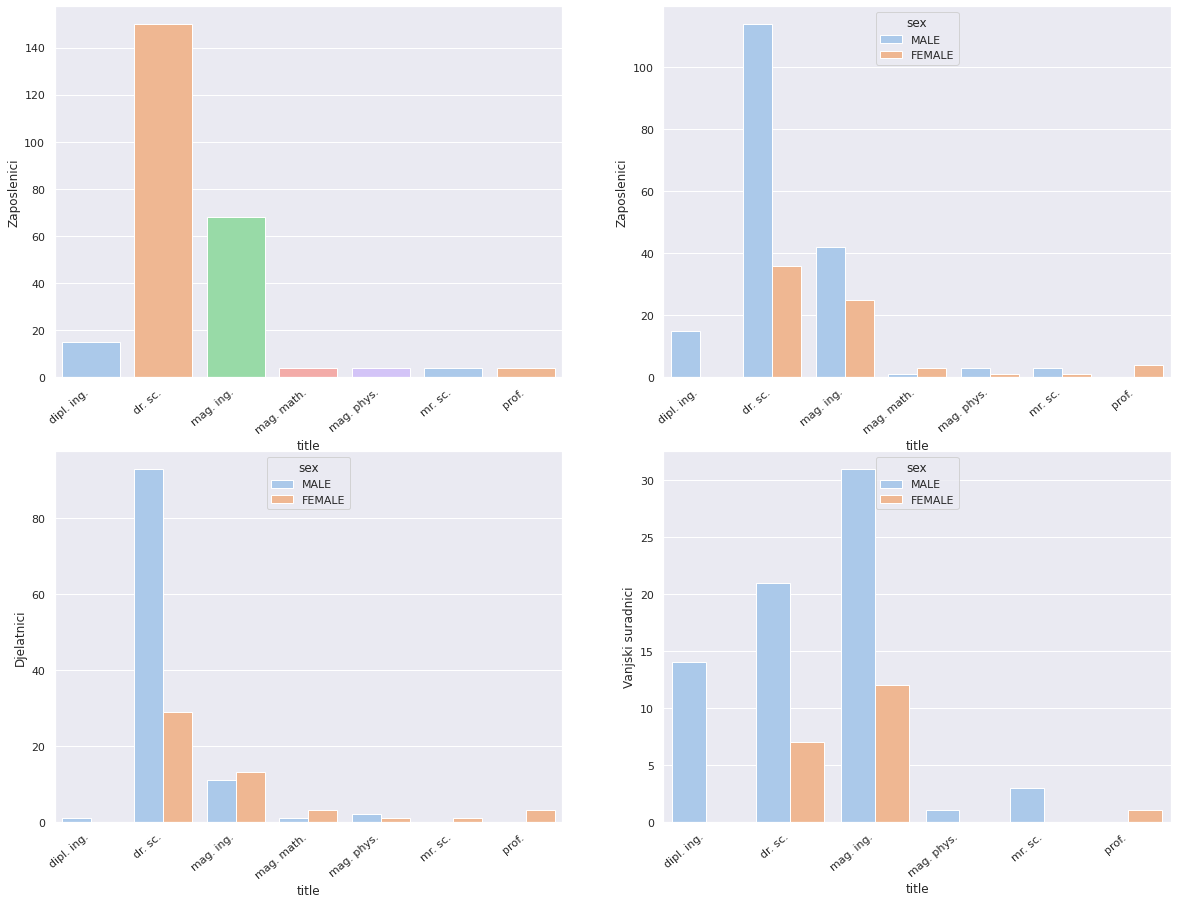

In [ ]:
df_all=employees
df_djelatnik=employees[employees["type"]=="djelatnik"]
df_vanjski_suradnik=employees[employees["type"]=="vanjski_suradnik"]


df_0=df_all.groupby(["title"]).size().reset_index(name="Zaposlenici").sort_values(by=['title'])
df_all=df_all.groupby(["sex", "title"]).size().reset_index(name="Zaposlenici").sort_values(by=['title'])
df_djelatnik=df_djelatnik.groupby(["sex", "title"]).size().reset_index(name="Djelatnici").sort_values(by=['title'])
df_vanjski_suradnik=df_vanjski_suradnik.groupby(["sex", "title"]).size().reset_index(name="Vanjski suradnici").sort_values(by=['title'])

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))
axs[0][0].set_xticklabels(axs[0][0].get_xticklabels(), rotation=40, ha="right")
axs[0][1].set_xticklabels(axs[0][1].get_xticklabels(), rotation=40, ha="right")
axs[1][0].set_xticklabels(axs[1][0].get_xticklabels(), rotation=40, ha="right")
axs[1][1].set_xticklabels(axs[1][1].get_xticklabels(), rotation=40, ha="right")

# drawing the plot
sns.barplot(data=df_0, x="title", y="Zaposlenici", ax=axs[0][0],palette=palette_color)
sns.barplot(data=df_all, x="title", y="Zaposlenici", hue="sex", ax=axs[0][1],palette=palette_color)
sns.barplot(data=df_djelatnik, x="title", y="Djelatnici", hue="sex", ax=axs[1][0],palette=palette_color)
sns.barplot(data=df_vanjski_suradnik, x="title", y="Vanjski suradnici", hue="sex", ax=axs[1][1],palette=palette_color)
plt.show()


Raspodjeljenost djelatnika po zavodima?

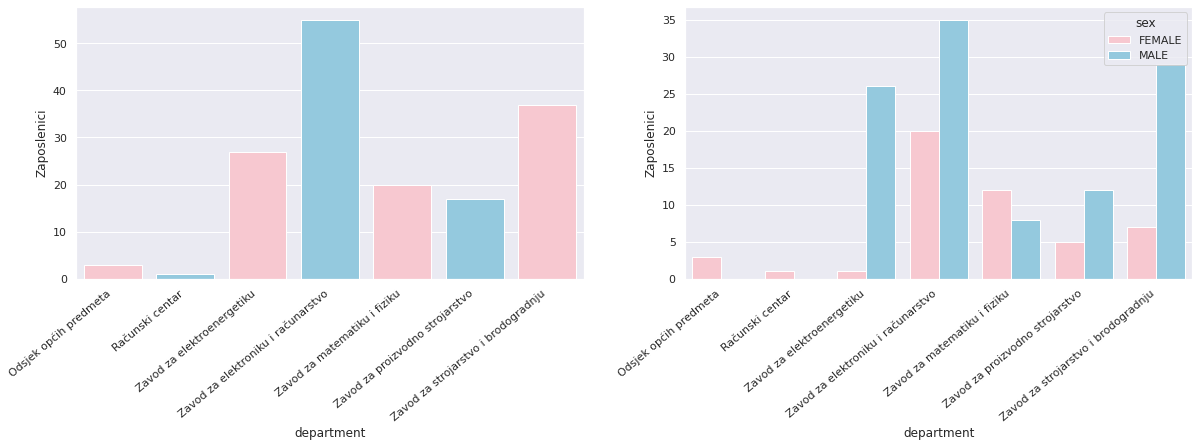

In [ ]:
df=employees.groupby(["department"]).size().reset_index(name="Zaposlenici")
df_by_sex=employees.groupby(["sex", "department"]).size().reset_index(name="Zaposlenici")

fig, axs = plt.subplots(ncols=2,figsize=(20, 5))
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=40, ha="right")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=40, ha="right")

sns.barplot(data=df, x="department", y="Zaposlenici", ax=axs[0],palette=colorPalete)
sns.barplot(data=df_by_sex, x="department", y="Zaposlenici", hue="sex", ax=axs[1],palette=colorPalete)

plt.show()

Raspodjeljenost djelatnika po pozicijama?

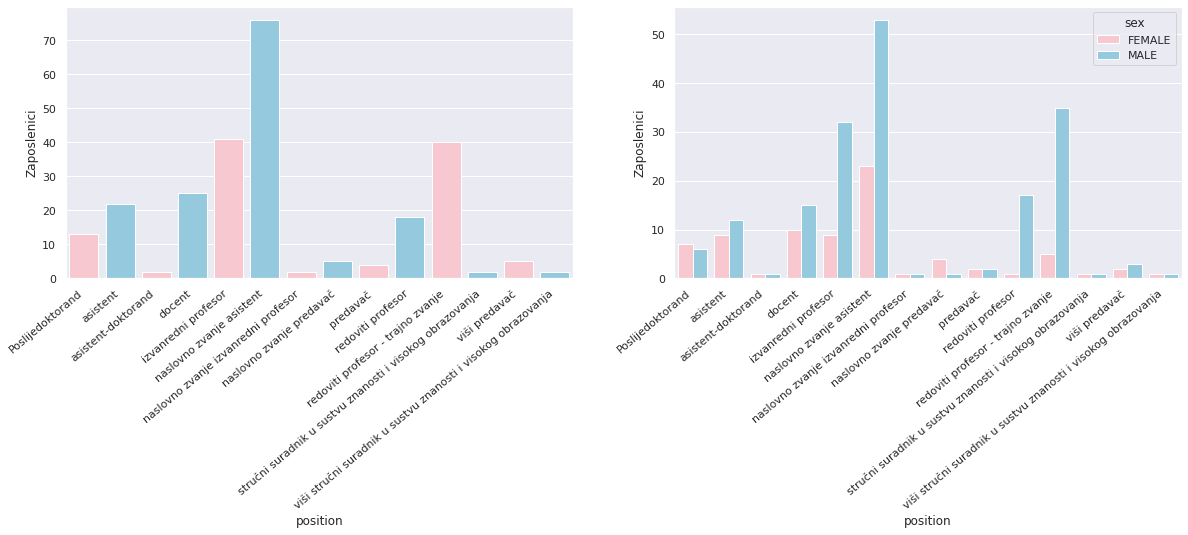

In [ ]:
df=employees.groupby(["position"]).size().reset_index(name="Zaposlenici")
df_by_sex=employees.groupby(["sex", "position"]).size().reset_index(name="Zaposlenici")

fig, axs = plt.subplots(ncols=2,figsize=(20, 5))
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=40, ha="right")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=40, ha="right")

sns.barplot(data=df, x="position", y="Zaposlenici", ax=axs[0],palette=colorPalete)
sns.barplot(data=df_by_sex, x="position", y="Zaposlenici", hue="sex", ax=axs[1],palette=colorPalete)

plt.show()



Raspodjeljenost titula s obzirom na zavode.

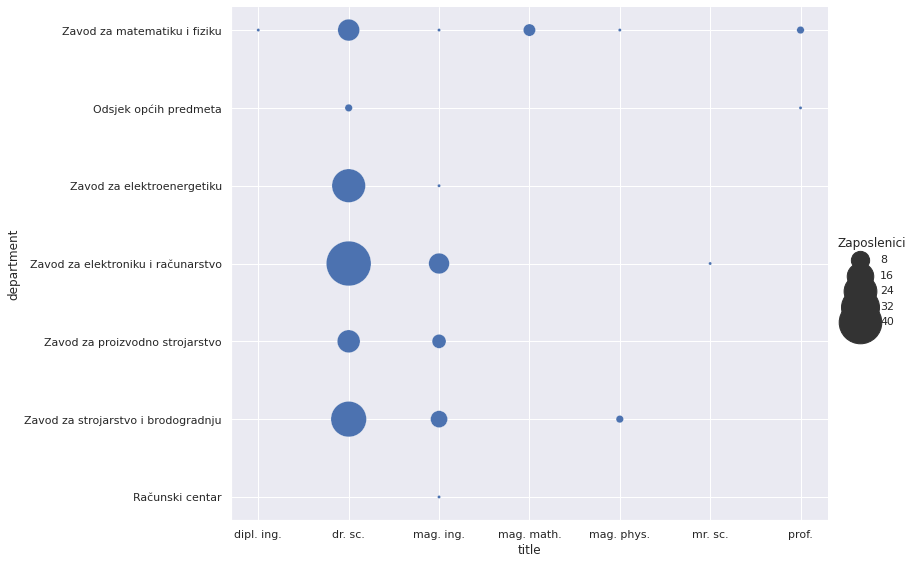

In [ ]:
df=employees.groupby(["title", "department"]).size().reset_index(name="Zaposlenici")
sns.relplot(data=df, x="title", y="department", size="Zaposlenici", height=8,aspect=1.5,sizes=(10, 2000))

Raspodjeljenost titula s obzirom na poziciju.

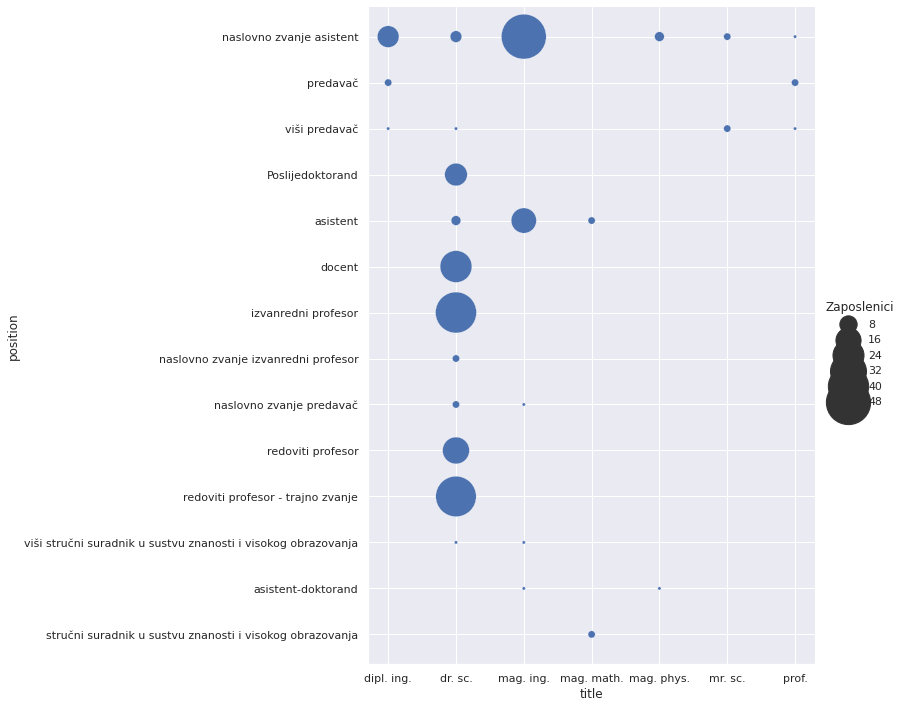

In [ ]:
df=employees.groupby(["title", "position"]).size().reset_index(name="Zaposlenici")
sns.relplot(data=df, x="title", y="position", size="Zaposlenici", height=10,aspect=1.2,sizes=(10, 2000))

## Daljnje analize
Koristeći postojeće podatke stvaranje novih podataka te sveukupna analiza.

### Pronađimo zaposlenike koji su mijenjali prezime
Pomoću usporedbe prezimena s prezimenom iz e-mail adrese.

Definiranje fukncije za izvlačenje prezimena iz e-mail adrese.

In [ ]:
def getLastNameFromEmail(email):
    prezime = re.search(r"^(\D*)(\.[0-9]+){0,1}(@fesb\.hr)", email) # xxxxxxxx.00@fesb.hr
    if prezime and '-' not in prezime.group(1):
      parts=prezime.group(1).split('.')
      if len(parts)==2: # xxxx.xxxx
        return parts[1] # xxxx
      else:
        return 'NULL'
    else:
      return 'NULL'

# TEST
prezime=getLastNameFromEmail("Josip.Basic.Brod@fesb.hr")
print(prezime)

NULL


Definiranje fukncije za uspoređivanje prezimena iz emaila s postojećim prezimenom, UTF-8 i ASCII iz emaila.

In [ ]:
def namesEqual(utf_s,ascii_s):
    
    dictionary = {'Č':'C', 'Ć':'C', 'Đ':'DZ', 'Š':'S', 'Ž':'Z', 'Ö':'O', 'Đ':'DJ' } 

    utf_s=utf_s.upper()
    ascii_s=ascii_s.upper()
    
    # UTF-8 to ASCII coversion
    for key in dictionary.keys():
        utf_s = utf_s.replace(key, dictionary[key])
    
    return ascii_s==utf_s


# TEST
print("Prezime nije mijenjano (nije se udala)" if namesEqual("Bašić",prezime) else "Prezime je mijenjano (udala se)") # kako neinitutitivno izvesti ternarni operator

Prezime je mijenjano (udala se)


Iteriranje kroz sve zaposlenike i dodavanje novog stupca, `changedLastName` koji može biti `true`, `false`, `NULL` (ukoliko se nije moglo odrediti, dupla prezimena...).

In [ ]:
employees['changedLastName'] = "NULL"

invalidLinkCounter=0
changed=0
notChanged=0

for index, row in employees.iterrows():
    email=row['email']
    if(email == email): # some weird python crap, NaN
      emailLastName = getLastNameFromEmail(email)
      if emailLastName != 'NULL':
        if namesEqual(row['lastName'],emailLastName):
          employees.at[index,'changedLastName'] = False
          notChanged+=1
        else:
          employees.at[index,'changedLastName'] = True
          changed+=1
      else:
        invalidLinkCounter+=1
  
sum=invalidLinkCounter+changed+notChanged
print("Number of special cases: ",invalidLinkCounter,"/",sum)
print("Changed Last Name: ",changed,"/",sum)
print("Not changed Last Name: ",notChanged,"/",sum)

Number of special cases:  42 / 274
Changed Last Name:  15 / 274
Not changed Last Name:  217 / 274


Koliko je muških/ženskih mijenjalo prezime?

Male:  0 / 15
Female:  15 / 15


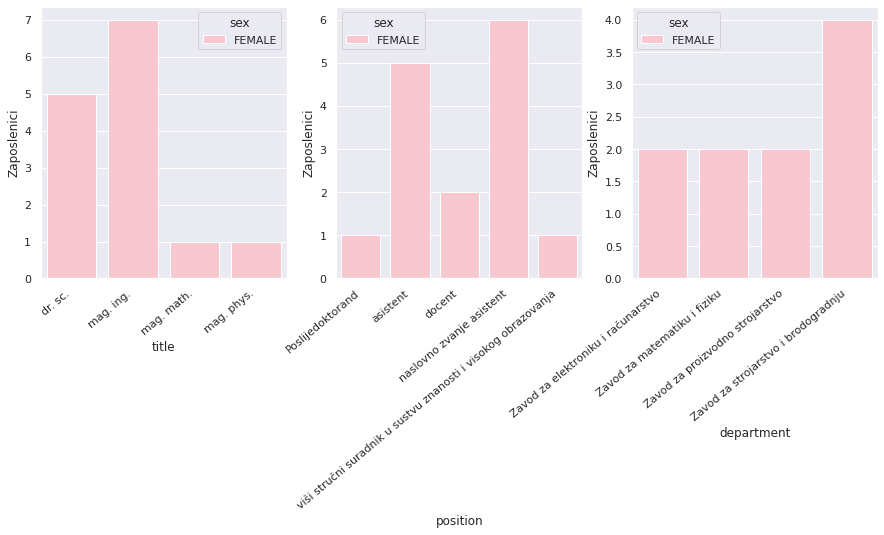

In [ ]:
df = employees[employees['changedLastName']==True]

print("Male: ",len(df[df["sex"]=='MALE']),"/",len(df))
print("Female: ",len(df[df["sex"]=='FEMALE']),"/",len(df))
# print(df[['lastName', 'email']]) # GDPR !!!


fig, axs = plt.subplots(ncols=3,figsize=(15, 5))
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=40, ha="right")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=40, ha="right")
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=40, ha="right")


df1=df.groupby(["sex", "title"]).size().reset_index(name="Zaposlenici")
sns.barplot(data=df1, x="title", y="Zaposlenici", hue="sex", ax=axs[0],palette=colorPalete)



df2=df.groupby(["sex", "position"]).size().reset_index(name="Zaposlenici")
sns.barplot(data=df2, x="position", y="Zaposlenici", hue="sex", ax=axs[1],palette=colorPalete)


df3=df.groupby(["sex", "department"]).size().reset_index(name="Zaposlenici")
sns.barplot(data=df3, x="department", y="Zaposlenici", hue="sex", ax=axs[2],palette=colorPalete)

plt.show()

# Google Scholar merge
- spajanje trenutnih podataka s podacima scrapeanih s Google Scholar-a

Dodavanje novog stupca `fullName`.

In [ ]:
employees['Title'] = employees[['firstName', 'lastName']].agg(' '.join, axis=1)
print(employees.shape)
employees.head()

(276, 17)


,Unnamed: 0,Unnamed: 0.1,detailsLink,image,lastName,firstName,deparment,location,details,sex,email,katedra,title,position,changedLastName,fullName,Title
0,0,0,https://nastava.fesb.unist.hr/nastava/nastavni...,NaN,Aljinović,Amanda,ZPS,C405,djelatnik,FEMALE,Amanda.Aljinovic@fesb.hr,Zavod za proizvodno strojarstvo,mag. ing.,asistent,False,Amanda Aljinović,Amanda Aljinović
1,1,1,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.unist.hr/slika/mala/pstr...,Bagavac,Petra,ZSB,C705,djelatnik,FEMALE,Petra.Bagavac@fesb.hr,Zavod za strojarstvo i brodogradnju,dr. sc.,Poslijedoktorand,False,Petra Bagavac,Petra Bagavac
2,2,2,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/dbajic.jpg,Bajić,Dražen,ZPS,NaN,djelatnik,MALE,Drazen.Bajic@fesb.hr,Zavod za proizvodno strojarstvo,dr. sc.,redoviti profesor - trajno zvanje,False,Dražen Bajić,Dražen Bajić
3,3,3,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/darioban.jpg,Ban,Dario,ZSB,C804,djelatnik,MALE,Dario.Ban@fesb.hr,Zavod za strojarstvo i brodogradnju,dr. sc.,izvanredni profesor,False,Dario Ban,Dario Ban
4,4,4,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/fbarbir.jpg,Barbir,Frano,ZSB,C513,djelatnik,MALE,Frano.Barbir@fesb.hr,Zavod za strojarstvo i brodogradnju,dr. sc.,redoviti profesor - trajno zvanje,False,Frano Barbir,Frano Barbir


Učitavanje Google Schoolar dataframe-a.

In [ ]:
schoolar = pd.read_csv("GoogleScholarData.csv")

print(schoolar.shape)
schoolar.head()

(110, 15)


,Title,Title_URL,Image,gs_ai_aff,gs_ai_eml,Number,gs_ai_one_int_URL,gs_ai_one_int,gs_ai_one_int_URL1,gs_ai_one_int2,gs_ai_one_int_URL3,gs_ai_one_int4,Unnamed: 12,Unnamed: 13,hi
0,Ivica Puljak,https://scholar.google.com/citations?hl=en&use...,https://scholar.googleusercontent.com/citation...,"University of Split, Faculty of Electrical Eng...",Verified email at fesb.hr,Cited by 189705,https://scholar.google.com/citations?hl=en&vie...,High energy physics,https://scholar.google.com/citations?hl=en&vie...,Astroparticle physics,https://scholar.google.com/citations?hl=en&vie...,Instrumentation,NaN,NaN,194
1,Nikola Godinovic,https://scholar.google.com/citations?hl=en&use...,https://scholar.googleusercontent.com/citation...,University of Split,Verified email at fesb.hr,Cited by 185274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187
2,Sven Gotovac,https://scholar.google.com/citations?hl=en&use...,https://scholar.googleusercontent.com/citation...,"Professor electrical engineering, University o...",Verified email at fesb.hr,Cited by 54439,https://scholar.google.com/citations?hl=en&vie...,Parallel computing,https://scholar.google.com/citations?hl=en&vie...,Image processing,https://scholar.google.com/citations?hl=en&vie...,Artificial inteligence,NaN,NaN,108
3,Linda Vicković,https://scholar.google.com/citations?hl=en&use...,https://scholar.google.com/citations/images/av...,"Assistant professor, University of Split",Verified email at fesb.hr,Cited by 50329,https://scholar.google.com/citations?hl=en&vie...,Software engineering,https://scholar.google.com/citations?hl=en&vie...,Complex data storage systems simulation and …,NaN,NaN,NaN,NaN,107
4,Petra Loncar,https://scholar.google.com/citations?hl=en&use...,https://scholar.google.com/citations/images/av...,"University of Split, Faculty of Electrical Eng...",Verified email at fesb.hr,Cited by 8756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56


Merge dvaju dataframe-a.

In [ ]:
print(employees.shape)
employeesSchoolar=employees.merge(schoolar, how='right', left_on='fullName', right_on='Title')
print(employeesSchoolar.shape)
employeesSchoolar.head()

(276, 17)
(110, 32)


,Unnamed: 0,Unnamed: 0.1,detailsLink,image,lastName,firstName,deparment,location,details,sex,...,Number,gs_ai_one_int_URL,gs_ai_one_int,gs_ai_one_int_URL1,gs_ai_one_int2,gs_ai_one_int_URL3,gs_ai_one_int4,Unnamed: 12,Unnamed: 13,hi
0,236.0,236.0,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/puljak.jpg,Puljak,Ivica,NaN,B705,vanjski_suradnik,MALE,...,Cited by 189705,https://scholar.google.com/citations?hl=en&vie...,High energy physics,https://scholar.google.com/citations?hl=en&vie...,Astroparticle physics,https://scholar.google.com/citations?hl=en&vie...,Instrumentation,NaN,NaN,194
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Cited by 185274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187
2,54.0,54.0,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/gotovac.jpg,Gotovac,Sven,ZER,NaN,djelatnik,MALE,...,Cited by 54439,https://scholar.google.com/citations?hl=en&vie...,Parallel computing,https://scholar.google.com/citations?hl=en&vie...,Image processing,https://scholar.google.com/citations?hl=en&vie...,Artificial inteligence,NaN,NaN,108
3,150.0,150.0,https://nastava.fesb.unist.hr/nastava/nastavni...,https://korisnik.fesb.hr/slika/mala/linda.jpg,Vicković,Linda,ZER,B509,djelatnik,FEMALE,...,Cited by 50329,https://scholar.google.com/citations?hl=en&vie...,Software engineering,https://scholar.google.com/citations?hl=en&vie...,Complex data storage systems simulation and …,NaN,NaN,NaN,NaN,107
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Cited by 8756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56
